Data Loading and Cleaning


In [4]:
## choose only date, location and new cases
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
df = df[['date', 'location', 'new_cases']].copy()
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] <= "2024-08-31"]
df['new_cases'] = df['new_cases'].fillna(0)

In [5]:
len(df)

429435

In [ ]:

## display first 5 records and last 5 records
df.head()
df.tail()
print("Concatenate first 5 and last 5 records:\n", pd.concat([df.head(), df.tail()]))

Concatenate first 5 and last 5 records:
              date     location  new_cases
0      2020-01-05  Afghanistan        0.0
1      2020-01-06  Afghanistan        0.0
2      2020-01-07  Afghanistan        0.0
3      2020-01-08  Afghanistan        0.0
4      2020-01-09  Afghanistan        0.0
429430 2024-07-31     Zimbabwe        0.0
429431 2024-08-01     Zimbabwe        0.0
429432 2024-08-02     Zimbabwe        0.0
429433 2024-08-03     Zimbabwe        0.0
429434 2024-08-04     Zimbabwe        0.0


There are 429,435 records in the dataset



In [ ]:
## check if there are missing values for the 3 variables (2 feature, and 1 target)
df.isnull().sum()

date         0
location     0
new_cases    0
dtype: int64

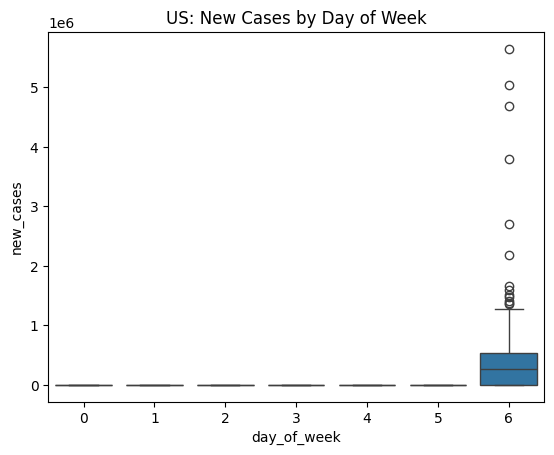

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

## Example: Weekly pattern
df['day_of_week'] = df['date'].dt.dayofweek
sns.boxplot(data=df[df['location'] == 'United States'], x='day_of_week', y='new_cases')
plt.title("US: New Cases by Day of Week")
plt.show()

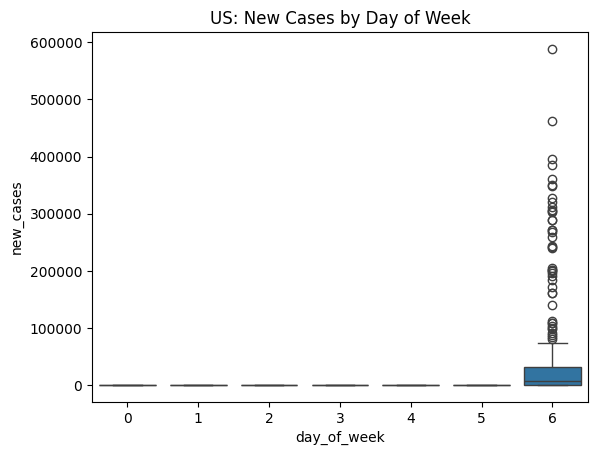

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

## Example: Weekly pattern
df['day_of_week'] = df['date'].dt.dayofweek
sns.boxplot(data=df[df['location'] == 'Australia'], x='day_of_week', y='new_cases')
plt.title("US: New Cases by Day of Week")
plt.show()

Run below training , it will produce xgboost models per country, regression_evaluation.csv  file, and the classification_evaluation.csv file 


For the Area under Curve  if it is low, then it is random, if it is high like 0.9 or higher, then it is good and outstanding



In [13]:
# training 
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    roc_auc_score
)

# ==============================
# CONFIGURATION
# ==============================
DATA_URL = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
CUTOFF_DATE = "2024-06-01"          # End of training data
TEST_START = "2024-06-01"           # Start of final evaluation
TEST_END = "2024-08-31"             # Last reliable data
MIN_HIST_DAYS = 30                  # Min days to train a country model

# Best XGBoost params (tuned or baseline)
BEST_PARAMS = {
    "max_depth": 4,
    "learning_rate": 0.1,
    "n_estimators": 150,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "random_state": 42
}

# ==============================
# HELPER FUNCTIONS
# ==============================
def create_lag_features(group, max_lag=7):
    group = group.set_index('date').sort_index()
    for lag in range(1, max_lag + 1):
        group[f'lag_{lag}'] = group['new_cases'].shift(lag)
    return group.reset_index().dropna()

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# ==============================
# MAIN TRAINING & EVALUATION
# ==============================
def main():
    print("📥 Loading and cleaning data...")
    df = pd.read_csv(DATA_URL, usecols=['date', 'location', 'new_cases'])
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'] <= pd.Timestamp(TEST_END)]
    df['new_cases'] = df['new_cases'].fillna(0)

    # Exclude aggregates
    exclude = ['World', 'High income', 'Upper middle income', 'Lower middle income', 'Low income']
    df = df[~df['location'].isin(exclude)]
    df.to_csv('cleaned_covid_data.csv', index=False)

    # Split: training = before cutoff
    train_df = df[df['date'] < CUTOFF_DATE].copy()
    test_df = df[(df['date'] >= TEST_START) & (df['date'] <= TEST_END)].copy()

    print(f"🌍 Training models for countries with ≥{MIN_HIST_DAYS} days of data...")
    models = {}
    regression_results = []

    # For ROC AUC: collect binary labels and scores across all countries
    binary_labels = []
    binary_scores = []

    for country in train_df['location'].unique():
        country_train = train_df[train_df['location'] == country].copy()
        if len(country_train) < MIN_HIST_DAYS:
            continue

        # Create lag features and train
        feat_df = create_lag_features(country_train)
        if len(feat_df) < 10:
            continue

        X = feat_df[[f'lag_{i}' for i in range(1, 8)]]
        y = feat_df['new_cases']
        model = XGBRegressor(**BEST_PARAMS)
        model.fit(X, y)
        models[country] = model

        # Evaluate on test period (June–Aug 2024)
        country_test = test_df[test_df['location'] == country]
        if country_test.empty:
            continue

        preds, actuals = [], []
        for _, row in country_test.iterrows():
            target_date = row['date']
            # Get last 7 days BEFORE target_date
            hist = df[
                (df['location'] == country) &
                (df['date'] < target_date)
            ].sort_values('date')

            if len(hist) < 7:
                continue

            last_7 = hist['new_cases'].tail(7).values
            pred = model.predict([last_7])[0]
            pred = max(0, pred)  # No negative cases

            preds.append(pred)
            actuals.append(row['new_cases'])

            # --- BINARY TASK: cases > 7-day avg? ---
            rolling_avg = hist['new_cases'].tail(7).mean()
            binary_label = 1 if row['new_cases'] > rolling_avg else 0
            # Use raw prediction as score (higher = more likely above avg)
            binary_score = pred

            binary_labels.append(binary_label)
            binary_scores.append(binary_score)

        # Regression metrics
        if actuals:
            mae = mean_absolute_error(actuals, preds)
            rmse = np.sqrt(mean_squared_error(actuals, preds))
            mape_val = mape(actuals, preds)
            r2 = r2_score(actuals, preds)
            regression_results.append({
                'country': country,
                'mae': round(mae, 2),
                'rmse': round(rmse, 2),
                'mape': round(mape_val, 2) if not np.isnan(mape_val) else None,
                'r2': round(r2, 4),
                'n_samples': len(actuals)
            })

    # Save models
    joblib.dump(models, 'covid_forecast_models.pkl')
    pd.DataFrame(regression_results).to_csv('regression_evaluation.csv', index=False)
    print("✅ Models and regression evaluation saved!")

    # Compute ROC AUC if possible
    if len(binary_labels) > 0 and len(set(binary_labels)) > 1:
        auc = roc_auc_score(binary_labels, binary_scores)
        summary = {
            'roc_auc_cases_above_7day_avg': round(auc, 4),
            'total_binary_samples': len(binary_labels),
            'positive_rate': round(np.mean(binary_labels), 4)
        }
        pd.DataFrame([summary]).to_csv('classification_evaluation.csv', index=False)
        print(f"📈 ROC AUC (cases > 7-day avg): {auc:.4f}")
    else:
        print("⚠️  Not enough variation in binary labels to compute ROC AUC.")

    print("\n📊 Evaluation complete!")
    print("   - Regression metrics: regression_evaluation.csv")
    print("   - Classification metrics: classification_evaluation.csv")

if __name__ == "__main__":
    main()

📥 Loading and cleaning data...
🌍 Training models for countries with ≥30 days of data...
✅ Models and regression evaluation saved!
📈 ROC AUC (cases > 7-day avg): 0.6282

📊 Evaluation complete!
   - Regression metrics: regression_evaluation.csv
   - Classification metrics: classification_evaluation.csv
